# Plot Dominguez 2023 incidence

In [9]:
import sys
import os
from pathlib import Path

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

HERE = Path.cwd()
PROJECT_ROOT = HERE.parents[1]
DATA_DIR = PROJECT_ROOT / "data"

In [10]:
# Load data
file_path = DATA_DIR / "crc_incidence.xlsx"
dominguez = pd.read_excel(file_path, sheet_name="dominguez_2023")
wang = pd.read_excel(file_path, sheet_name="NCCN")

In [11]:
columns = wang.iloc[7,1:6]
data_wang = wang.iloc[8:14, 1:6].reset_index(drop=True)
data_wang.columns = columns
data_wang.columns.name = None
data_wang['value'] /= 100.0
data_wang['lower'] /= 100.0
data_wang['upper'] /= 100.0
data_wang['se'] = (data_wang['upper']-data_wang['lower'])/(1.96*2.0)
data_wang['var'] = data_wang['se']**2
data_wang.to_csv(DATA_DIR / "targets/crc_incidence_by_70.csv", index=False)
data_wang

,gene,sex,value,lower,upper,se,var
0,MLH1,male,0.439,0.396,0.466,0.017857,0.000319
1,MSH2,male,0.539,0.49,0.563,0.018622,0.000347
2,MSH6,male,0.12,0.024,0.246,0.056633,0.003207
3,MLH1,female,0.373,0.322,0.402,0.020408,0.000416
4,MSH2,female,0.386,0.341,0.42,0.020153,0.000406
5,MSH6,female,0.123,0.035,0.232,0.050255,0.002526


### Number of patients per group (for se, weighting)

In [12]:
dataNcols = dominguez.iloc[117,1:4]
dataN = dominguez.iloc[118:126, 1: 4].reset_index(drop=True)
dataN.columns = dataNcols
dataN.columns.name = None
dataN['sex'] = dataN['sex'].str.lower()
dataN

,gene,sex,n
0,MLH1,female,1686
1,MLH1,male,1445
2,MSH2,female,1708
3,MSH2,male,1463
4,MSH6,female,884
5,MSH6,male,765
6,PMS2,female,310
7,PMS2,male,239


### Cumulative incidence by 5y ages until age 75

In [13]:
columns = dominguez.iloc[12,1:-3]
data = dominguez.iloc[13:61,1:-3].reset_index(drop=True)
data.columns = columns
data.columns.name = None
data['age'] = pd.to_numeric(data['age'], errors='coerce')
data['lower'] = pd.to_numeric(data['lower'], errors='coerce')
data['upper'] = pd.to_numeric(data['upper'], errors='coerce')
data['value'] /= 100
data['lower'] /= 100
data['upper'] /= 100
data['sex'] = data['sex'].str.lower()
data.head()

,gene,age,sex,value,lower,upper
0,MLH1,30,female,0.0,NaN,NaN
1,MLH1,40,female,0.09,0.063,0.128
2,MLH1,50,female,0.182,0.145,0.228
3,MLH1,60,female,0.306,0.258,0.361
4,MLH1,70,female,0.421,0.362,0.486


In [14]:
data = pd.merge(data, dataN, how="left", on=['gene', 'sex'])

def estimate_se(row):
    u, l = row.upper, row.lower
    # Use CI when both bounds are present
    if pd.notna(u) and pd.notna(l):
        return (u-l) / (1.96*2.0)
    
    # Fallback: binomial approx
    n = row.n
    p = row.value if row.value > 0 else 1.0/(2.0*n)
    se = 100 * ((p * (1-p))/n)**(1/2)
    return se

data['se'] = data.apply(estimate_se, axis="columns")
data['var'] = data['se']**2
data.head()

,gene,age,sex,value,lower,upper,n,se,var
0,MLH1,30,female,0.0,NaN,NaN,1686,0.041934,0.001758
1,MLH1,40,female,0.09,0.063,0.128,1686,0.016582,0.000275
2,MLH1,50,female,0.182,0.145,0.228,1686,0.021173,0.000448
3,MLH1,60,female,0.306,0.258,0.361,1686,0.026276,0.000690
4,MLH1,70,female,0.421,0.362,0.486,1686,0.031633,0.001001


In [ ]:
data.to_csv(DATA_DIR / "targets/crc_incidence_cumulative_to_75.csv", index=False)

In [ ]:
# Save shape csv
# compute per-age increment within each (gene, sex) group, keep MultiIndex
target_inc_curve = (
    data.groupby(["gene", "sex"])
      .apply(lambda g: g.sort_values("age").assign(diff=g["value"].diff()))
      .dropna(subset=["diff"])
)[['age','diff']].rename(columns={'diff':'value'})
target_inc_curve

/var/folders/m7/mpsrmwrn4qq669j2_9h94vjm0000gn/T/ipykernel_19192/389532291.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values("age").assign(diff=g["value"].diff()))


age  value
gene sex                  
MLH1 female 1    40   0.09
            2    50  0.092
            3    60  0.124
            4    70  0.115
            5    75  0.062
     male   7    40  0.116
            8    50  0.176
            9    60  0.134
            10   70  0.069
            11   75  0.032
MSH2 female 13   40  0.056
            14   50  0.085
            15   60  0.084
            16   70  0.156
            17   75  0.028
     male   19   40  0.067
            20   50  0.114
            21   60  0.169
            22   70  0.124
            23   75  0.048
MSH6 female 25   40  0.012
            26   50  0.028
            27   60  0.046
            28   70  0.087
            29   75    0.0
     male   31   40  0.031
            32   50  0.011
            33   60  0.049
            34   70  0.017
            35   75  0.029
PMS2 female 37   40    0.0
            38   50    0.0
            39   60    0.0
            40   70  0.085
            41   75    0.0
     male   43   40    0.0
            44   50    0.0
            45   60  0.105
            46   70    0.0
            47   75  0.223

In [18]:
target_inc_curve.to_csv(DATA_DIR / "targets/crc_incidence_curve_to_75.csv", index=["gene","sex"])

### Cumulative incidence by age 65

In [63]:
data65cols = dominguez.iloc[0,1:-3]
data65 = dominguez.iloc[1:9, 1: -3].reset_index(drop=True)
data65.columns = data65cols
data65.columns.name = None
data65.drop(columns='age', inplace=True)
data65['sex'] = data65['sex'].str.lower()
data65['se'] = (data65['upper'] - data65['lower']) / (2.0*1.96)
data65['var'] = data65['se']**2
data65

,gene,sex,value,lower,upper,se,var
0,MLH1,male,0.484,0.424,0.548,0.031633,0.001001
1,MSH2,male,0.415,0.348,0.488,0.035714,0.001276
2,MSH6,male,0.127,0.068,0.231,0.041582,0.001729
3,PMS2,male,0.095,0.025,0.329,0.077551,0.006014
4,MLH1,female,0.363,0.31,0.423,0.028827,0.000831
5,MSH2,female,0.298,0.246,0.358,0.028571,0.000816
6,MSH6,female,0.101,0.05,0.171,0.030867,0.000953
7,PMS2,female,0.028,0.004,0.182,0.045408,0.002062


In [64]:
data65 = pd.merge(data65, dataN, how="left", on=['gene','sex'])
data65.to_csv(DATA_DIR / "targets/crc_incidence_by_65.csv", index=False)

## Plot raw data

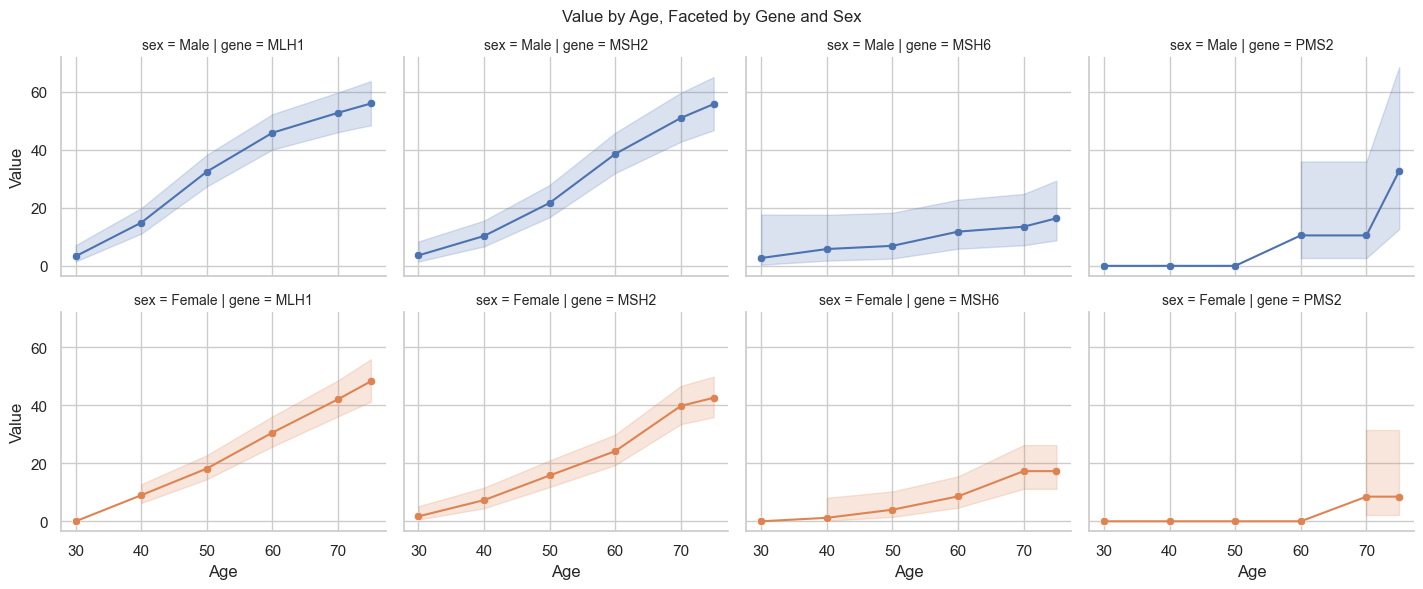

In [50]:
import seaborn as sns

# Create FacetGrid by gene
g = sns.FacetGrid(data, row='sex', col='gene', hue='sex', height=3, aspect=1.2, sharey=True)

# Plot line and confidence band
g.map_dataframe(sns.lineplot, x='age', y='value')
g.map_dataframe(sns.scatterplot, x='age', y='value')

# Add confidence intervals
def add_ci(data, color, **kwargs):
    plt.fill_between(data['age'], data['lower'], data['upper'], alpha=0.2, color=color)

g.map_dataframe(add_ci)

# Formatting
g.set_axis_labels("Age", "Value")
for ax in g.axes.flat:
    title = ax.get_title()
    ax.set_title(title, fontsize=10)
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Value by Age, Faceted by Gene and Sex", fontsize=12)
plt.show()

## Cubic spline interpolation

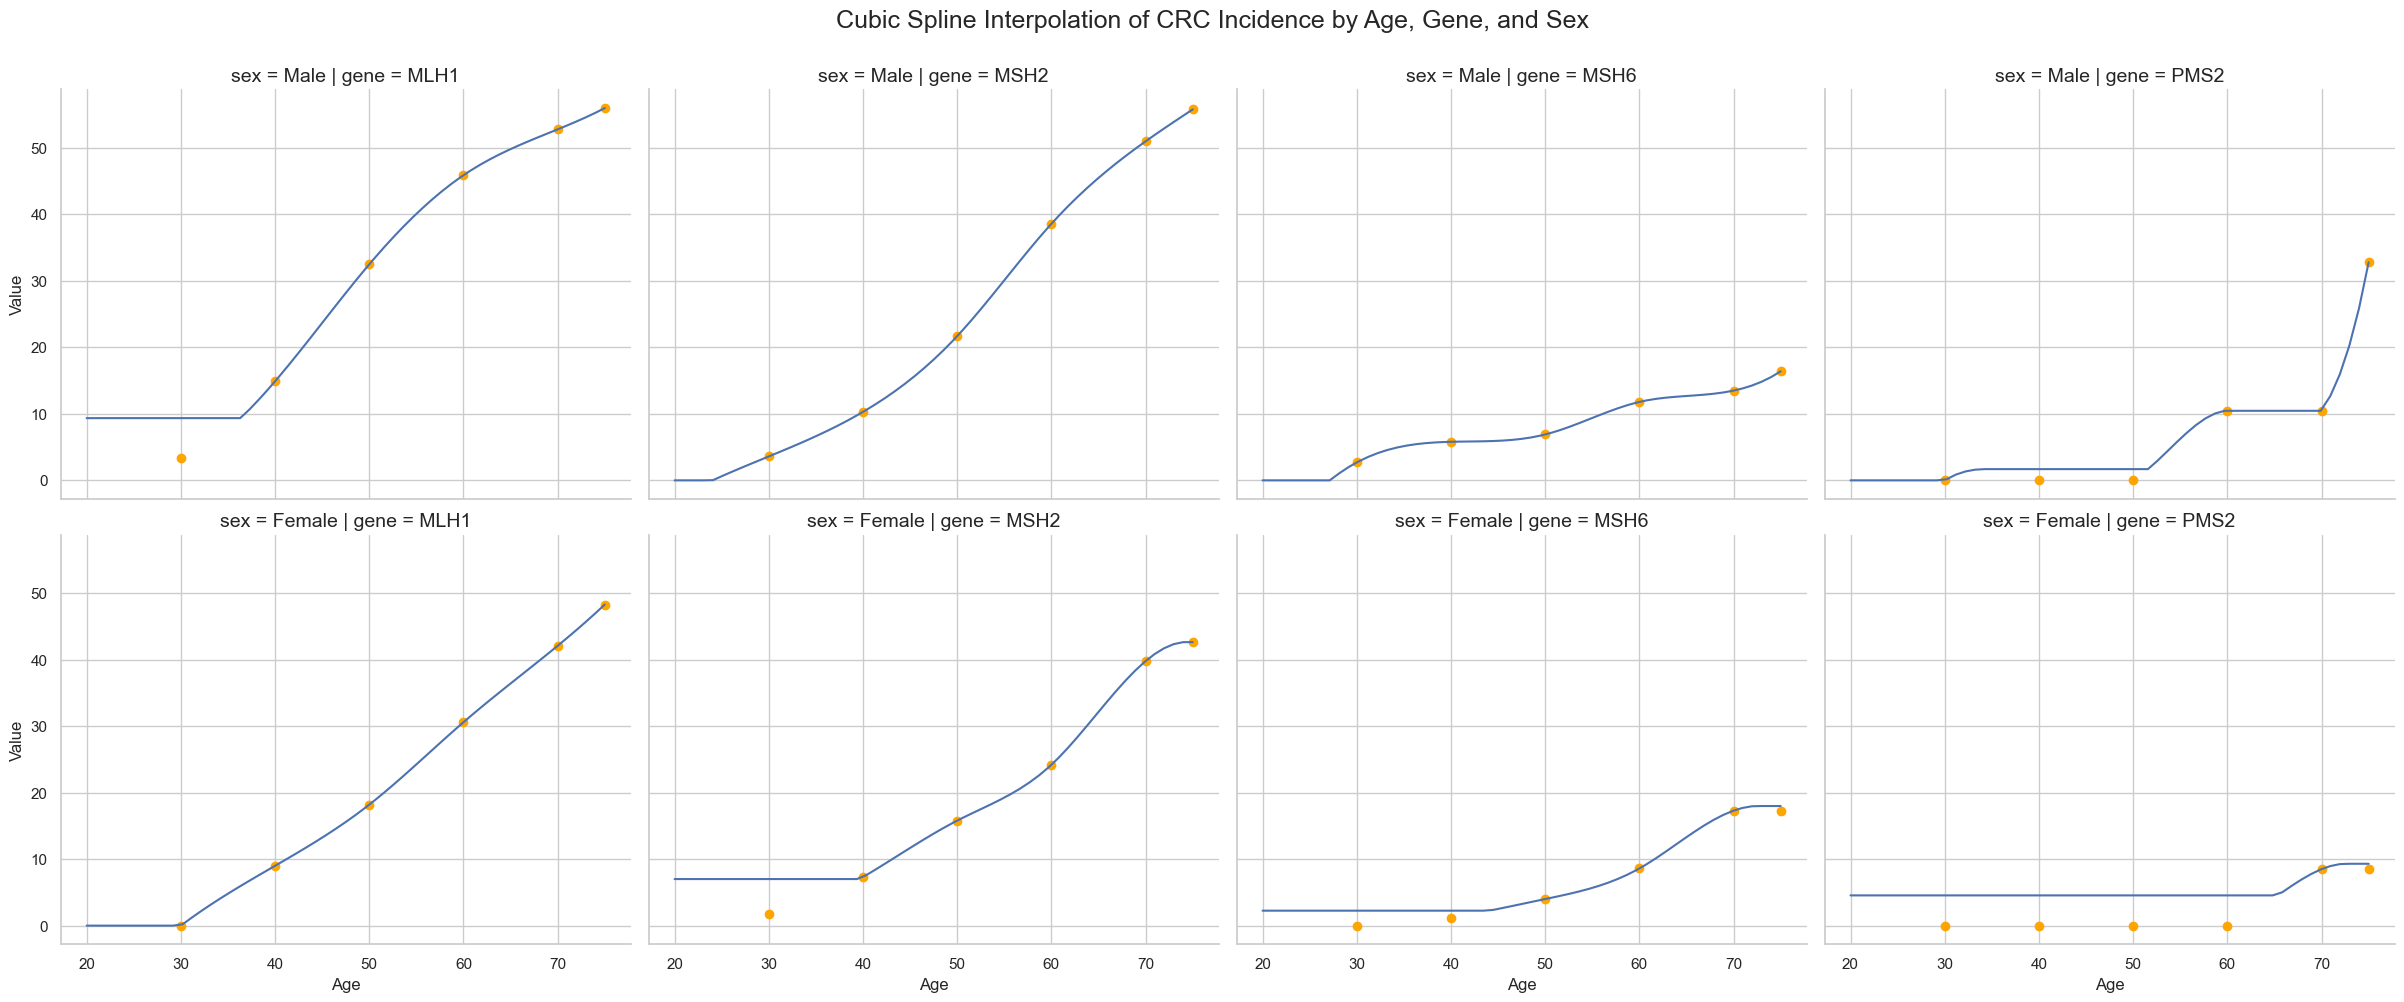

In [51]:
from scipy.interpolate import CubicSpline

# Define spline plotting function
def plot_spline(data, color=None, **kwargs):
    x = data['age'].dropna().values
    y = data['value'].dropna().values
    if len(x) > 1 and len(y) > 1:
        spline = CubicSpline(x, y)
        x_new = np.linspace(20, 75, 55)
        y_new = spline(x_new)
        y_new = np.clip(y_new, 0, None)  # Ensure no negative values
        y_new = np.maximum.accumulate(y_new)  # Ensure non-decreasing values
        plt.scatter(x, y, color="orange")
        plt.plot(x_new, y_new, color=color)
        

# Create FacetGrid
g = sns.FacetGrid(data, col='gene', row='sex', height=5, aspect=1.2, sharey=True)

# Map the spline plotting function
g.map_dataframe(plot_spline)

# Formatting
g.set_axis_labels("Age", "Value")
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=14)

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Cubic Spline Interpolation of CRC Incidence by Age, Gene, and Sex", fontsize=18)
plt.show()



## Csaps interpolation

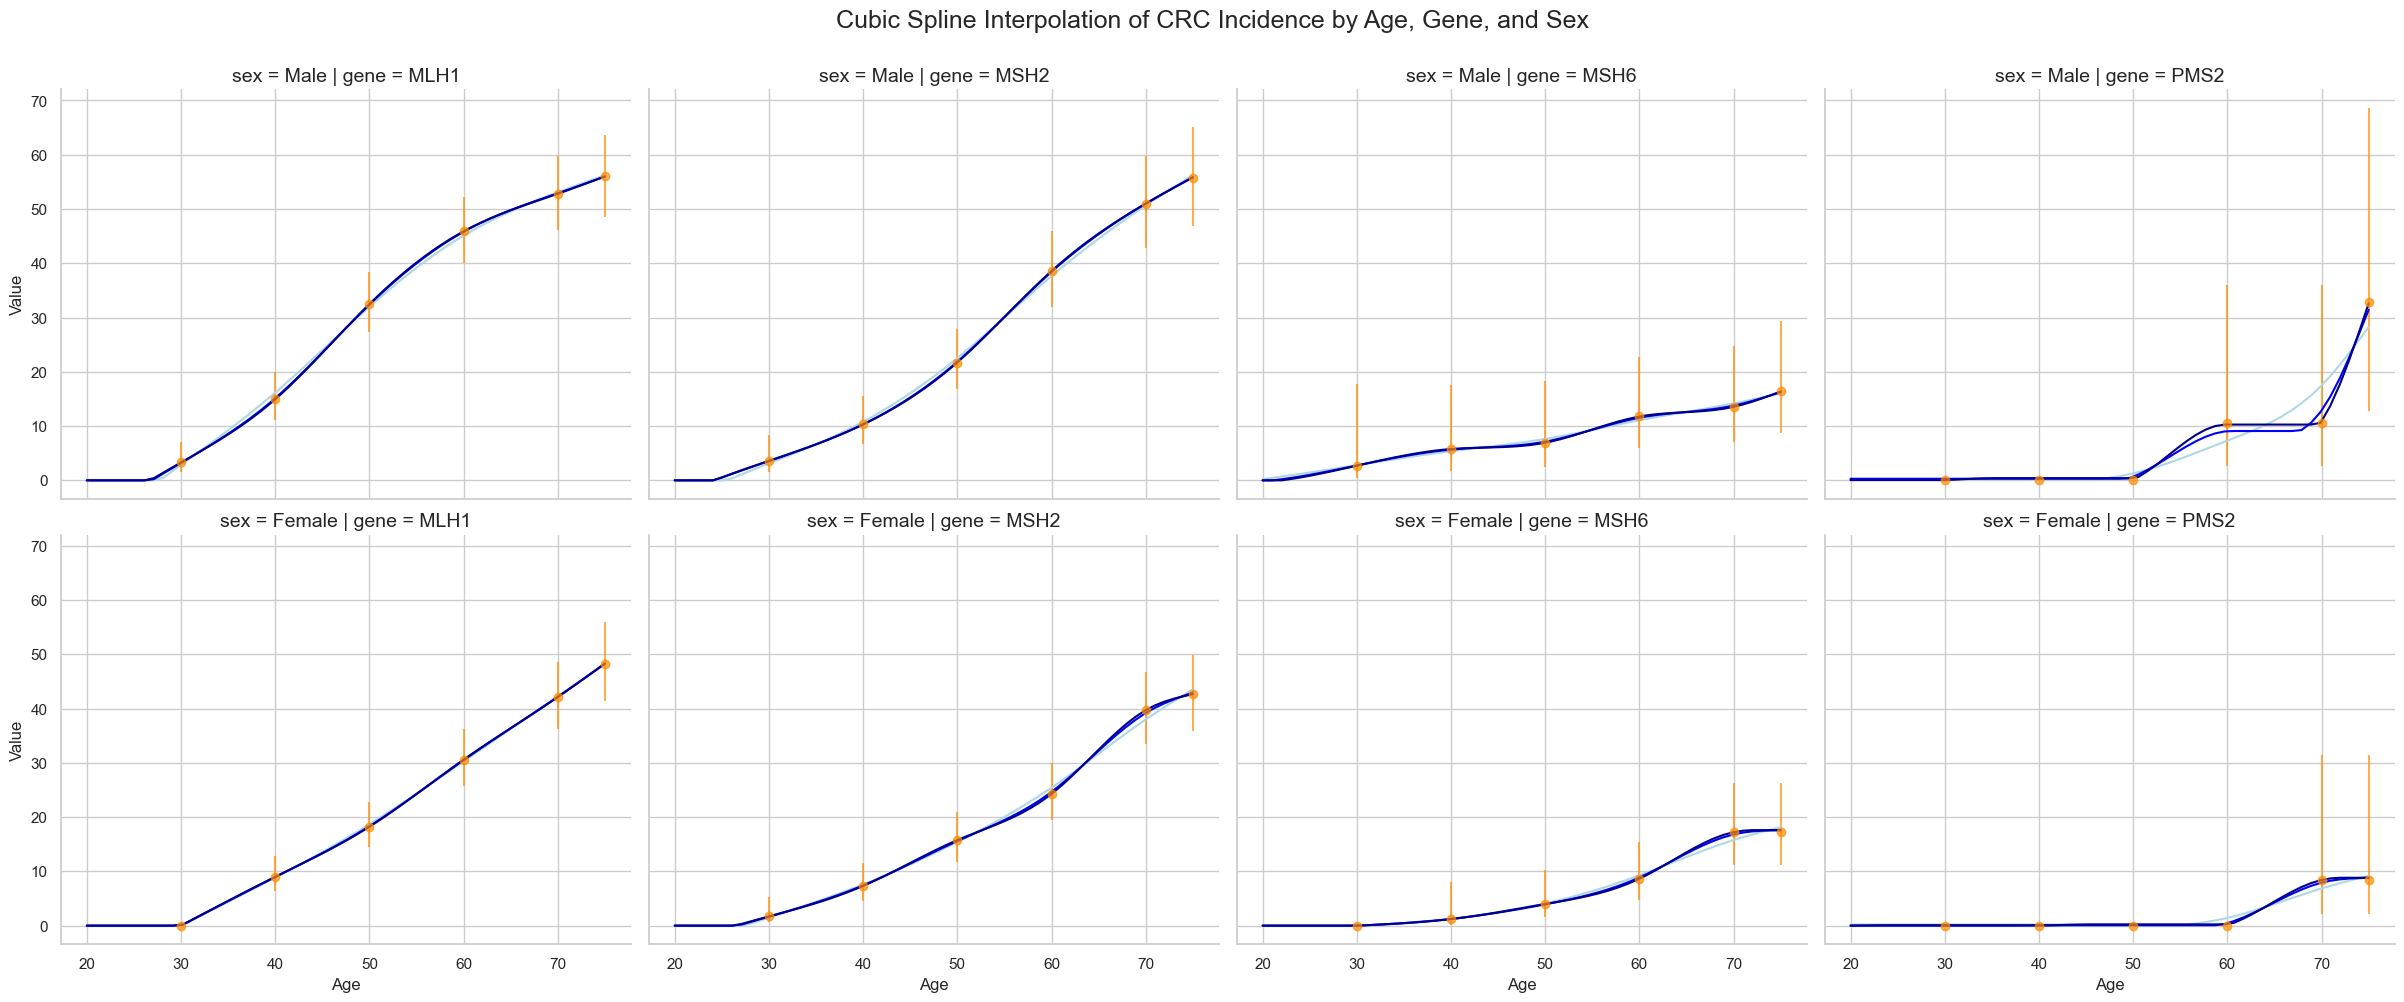

In [67]:
from csaps import csaps

# Define spline plotting function
def plot_spline(data, color=None, **kwargs):
    x = data['age'].dropna().values
    y = data['value'].dropna().values
    if len(x) > 1 and len(y) > 1:
        spline1 = csaps(x, y, smooth=0.01)
        spline2 = csaps(x, y, smooth=0.1)
        spline3 = csaps(x, y, smooth=0.5)
        x_new = np.linspace(20, 75, 55)
        y_new1 = spline1(x_new)
        y_new2 = spline2(x_new)
        y_new3 = spline3(x_new)
        # Raw points
        plt.errorbar(data['age'], data['value'], 
                yerr=[data['value'] - data['lower'], data['upper'] - data['value']],
                fmt='o', color='darkorange', alpha=0.7)
        #plt.scatter(x, y, color="orange")
        for y_new, mycolor in zip([y_new1, y_new2, y_new3],['lightblue', 'blue', 'darkblue']):
            y_new = np.clip(y_new, 0, None) # Ensure no negative values
            y_new = np.maximum.accumulate(y_new)  # Ensure non-decreasing values
            plt.plot(x_new, y_new, color=mycolor)     

# Create FacetGrid
g = sns.FacetGrid(data, col='gene', row='sex', hue='sex', height=5, aspect=1.2, sharey=True)

# Map the spline plotting function
g.map_dataframe(plot_spline)

# Formatting
g.set_axis_labels("Age", "Value")
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=14)

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Cubic Spline Interpolation of CRC Incidence by Age, Gene, and Sex", fontsize=18)
plt.show()



In [53]:
data_comb = data.groupby(['gene','age']).agg({
    'value': 'mean',
    'lower': 'mean',
    'upper': 'mean'
}).reset_index()
data_comb['sex'] = 'Combined'
data_all = pd.concat([data, data_comb], ignore_index=True)

## Moving average interpolation

In [58]:
def moving_average_interpolation(group, window_size=3):
    group = group.sort_values(by='age')
    group['value_ma'] = group['value'].rolling(window=window_size, center=True, min_periods=1).mean()
    return group


# Drop rows with missing CI
df_nonan = data.fillna({'lower': 0, 'upper': 0})
df_nonan['se'] = (df_nonan['upper'] - df_nonan['lower']) / (2 * 1.96)  # Calculate standard error from CI
df_nonan['se_fix'] = df_nonan['se'].copy()  # Create a copy for fixing
df_nonan.loc[df_nonan['se_fix'] <= 0, 'se_fix'] = 15  # Avoid division by 0 and give less weight
df_nonan['weight'] = 1 / (df_nonan['se_fix'] ** 2)  # Inverse variance weighting

# Weighted average across sexes
df_weighted = (
    df_nonan.groupby(['gene', 'age'])
    .apply(lambda g: pd.Series({
        'value': np.average(g['value'], weights=g['weight']),
        'lower': np.average(g['lower'], weights=g['weight']),
        'upper': np.average(g['upper'], weights=g['weight']),
        'sex': 'Combined'
    }))
    .reset_index()
)

data_all = pd.concat([data, df_weighted], ignore_index=True)

data_ma = data_all.groupby(['gene', 'sex']).apply(
    moving_average_interpolation
).reset_index(drop=True)

/var/folders/m7/mpsrmwrn4qq669j2_9h94vjm0000gn/T/ipykernel_10819/740732721.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
/var/folders/m7/mpsrmwrn4qq669j2_9h94vjm0000gn/T/ipykernel_10819/740732721.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_ma = data_all.groupby(['gene', 'sex']).apply(


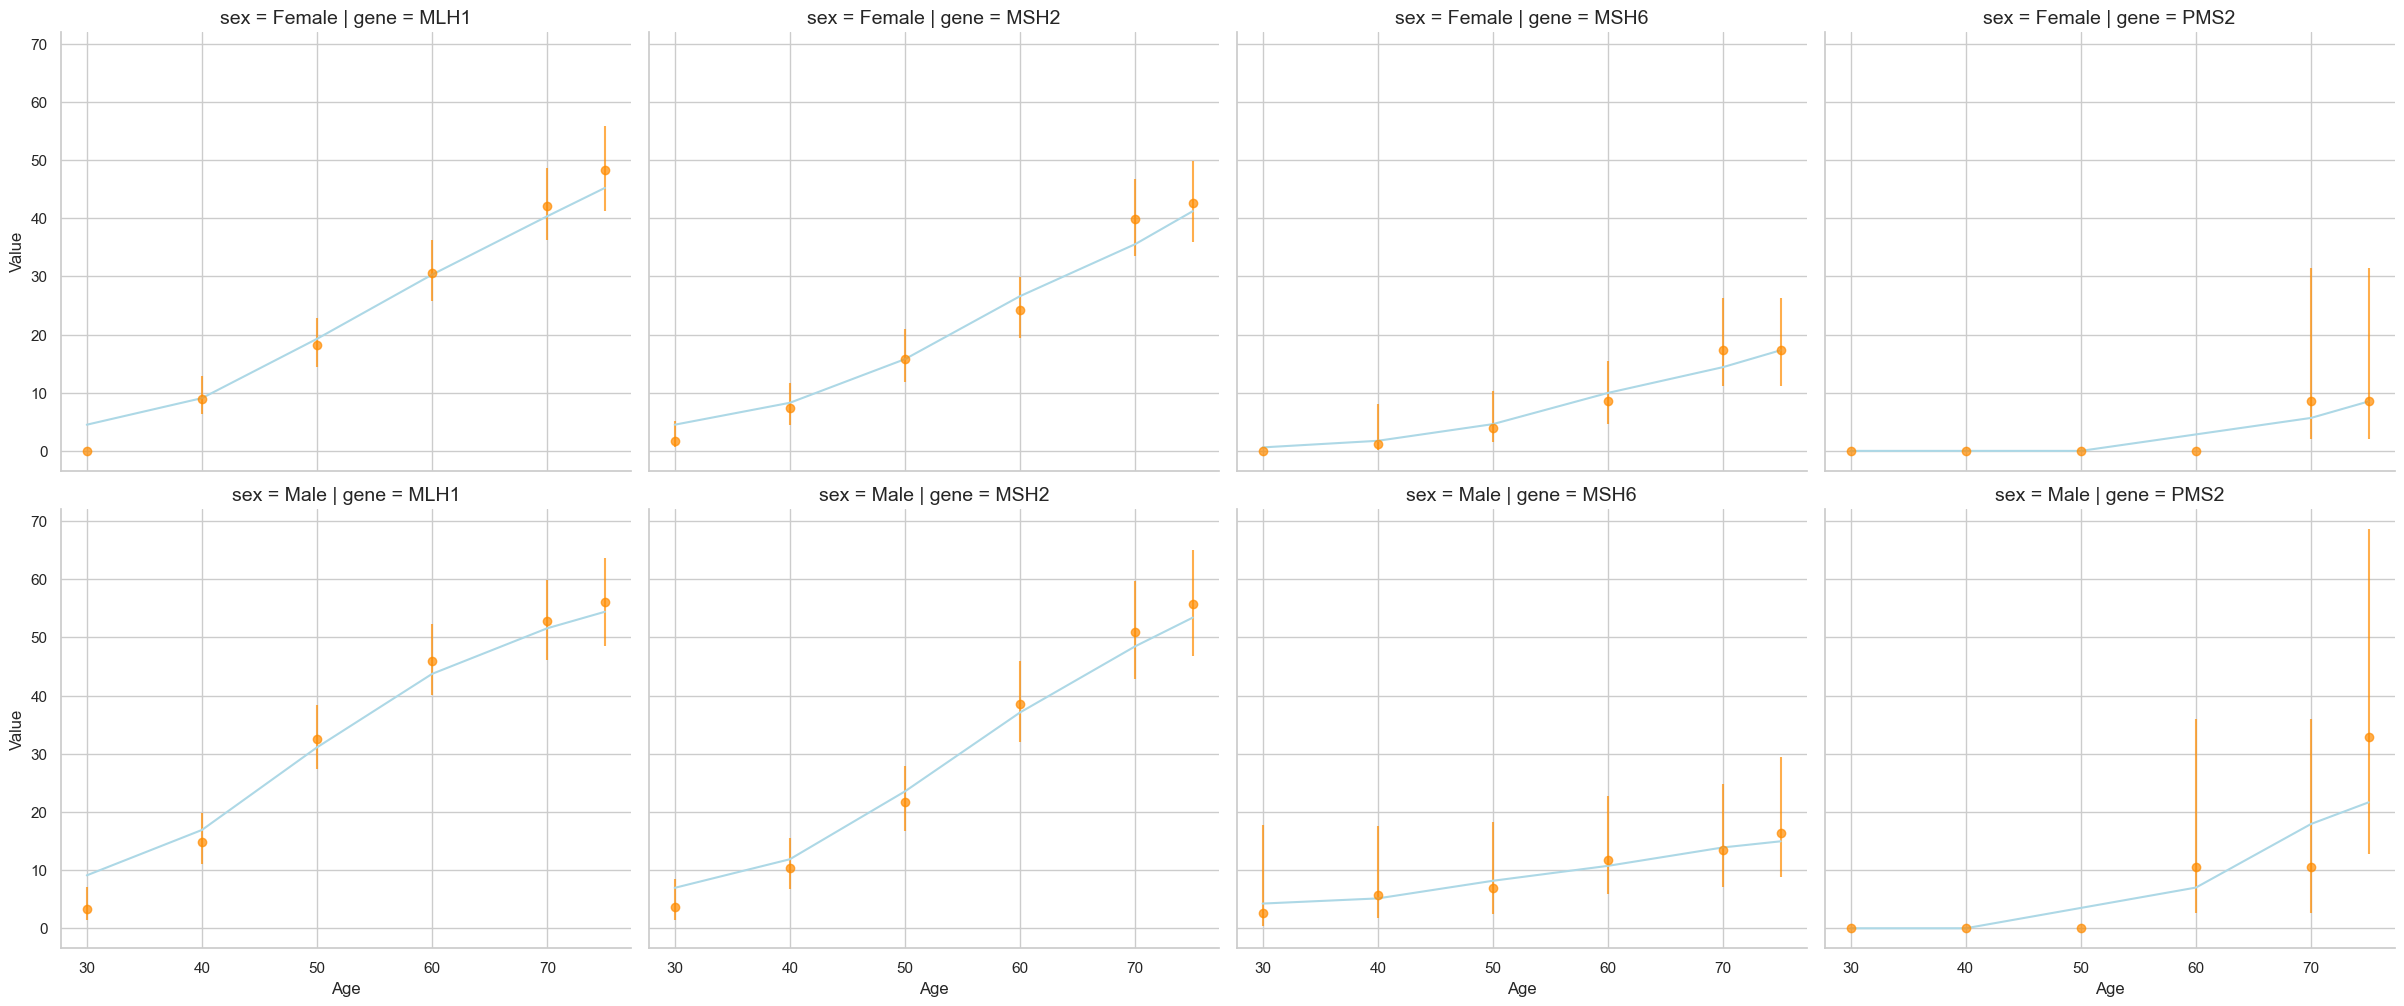

In [69]:
def plot_mas_by_sex(data, color=None, **kwargs):
    # Raw points
    plt.errorbar(data['age'], data['value'], 
                yerr=[data['value'] - data['lower'], data['upper'] - data['value']],
                fmt='o', color='darkorange', alpha=0.7)
    plt.plot(data['age'],
            data['value_ma'],
            label='Moving Avg', color='lightblue')

# Create FacetGrid
data_ma_by_sex = data_ma[data_ma['sex'] != 'Combined']  # Exclude combined data for this plot
g = sns.FacetGrid(data_ma_by_sex, row='sex', col='gene', hue='sex', height=5, aspect=1.2, sharey=True)

# Map the spline plotting function
g.map_dataframe(plot_mas_by_sex)

# Formatting
g.set_axis_labels("Age", "Value")
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=14)

## Moving average interpolation - combined sexes (possibly for PMS2 females?)

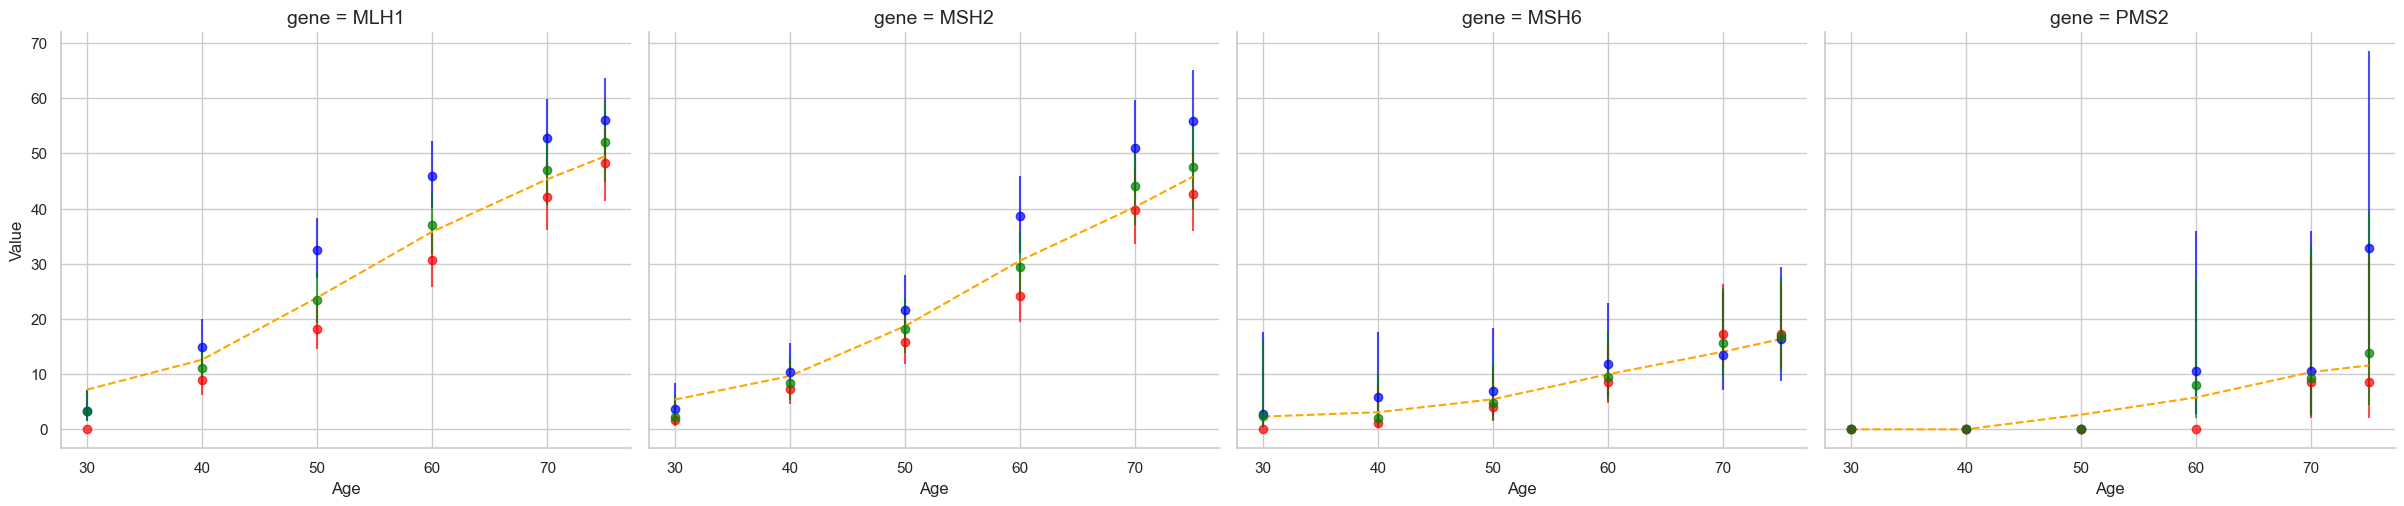

In [59]:
# Define spline plotting function
def plot_mas(data, color=None, **kwargs):
    samp_m = data[data['sex']=='Male']
    samp_f = data[data['sex']=='Female']
    samp_c = data[data['sex']=='Combined']

    # Raw points
    plt.errorbar(samp_m['age'], samp_m['value'], 
                yerr=[samp_m['value'] - samp_m['lower'], samp_m['upper'] - samp_m['value']],
                fmt='o', label='Observed Male', color='blue', alpha=0.7)
    plt.errorbar(samp_f['age'], samp_f['value'], 
                yerr=[samp_f['value'] - samp_f['lower'], samp_f['upper'] - samp_f['value']],
                fmt='o', label='Observed Female', color='red', alpha=0.7)
    plt.errorbar(samp_c['age'], samp_c['value'],
                yerr=[samp_c['value'] - samp_c['lower'], samp_c['upper'] - samp_c['value']],
                fmt='o', label='Observed Combined', color='green', alpha=0.7)

    # Moving average line
    plt.plot(data[data['sex']=='Combined']['age'],
            data[data['sex']=='Combined']['value_ma'],
            label='Moving Avg (Combined)', linestyle='--', color='orange')
    plt.legend()

# Create FacetGrid
g = sns.FacetGrid(data_ma, col='gene', height=5, aspect=1.2,sharey=True)

# Map the spline plotting function
g.map_dataframe(plot_mas)

# Formatting
g.set_axis_labels("Age", "Value")
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=14)



In [70]:
DATA_DIRM = os.path.join(PARENT_DIR, "DataM")
mlh1 = pd.read_csv(os.path.join(DATA_DIRM, "Nono_MLH1.csv"))
msh2 = pd.read_csv(os.path.join(DATA_DIRM, "Nono_MSH2.csv"))
msh6 = pd.read_csv(os.path.join(DATA_DIRM, "Nono_MSH6.csv"))
pms2 = pd.read_csv(os.path.join(DATA_DIRM, "Nono_PMS2.csv"))

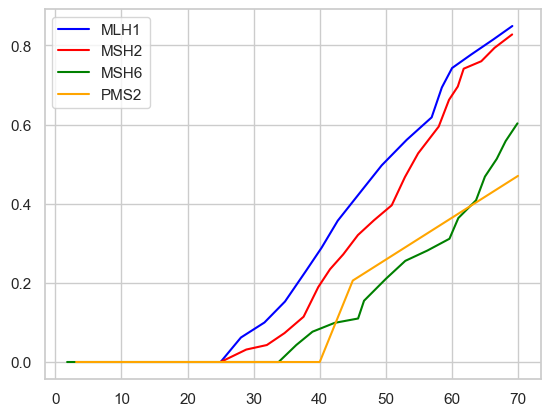

In [72]:
plt.plot(mlh1['x'], mlh1['Curve1'], label='MLH1', color='blue')
plt.plot(msh2['x'], msh2['Curve1'], label='MSH2', color='red')
plt.plot(msh6['x'], msh6['Curve1'], label='MSH6', color='green')
plt.plot(pms2['x'], pms2['Curve1'], label='PMS2', color='orange')
plt.legend()

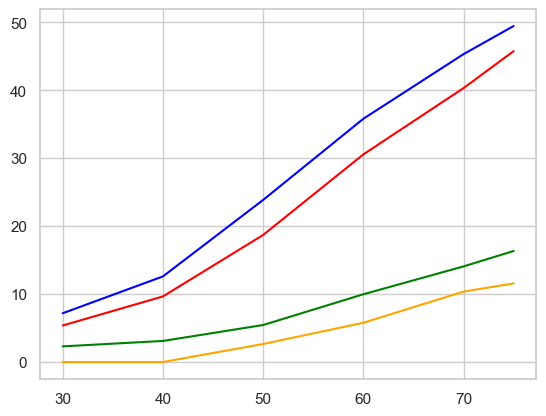

In [74]:
data_mas = data_ma[data_ma['sex'] == 'Combined']

plt.plot(data_mas[data_mas['gene']=='MLH1']['age'],
         data_mas[data_mas['gene']=='MLH1']['value_ma'],
         label='MLH1 Moving Avg', color='blue'
         )
plt.plot(data_mas[data_mas['gene']=='MSH2']['age'],
            data_mas[data_mas['gene']=='MSH2']['value_ma'],
            label='MSH2 Moving Avg', color='red'
            )
plt.plot(data_mas[data_mas['gene']=='MSH6']['age'],
            data_mas[data_mas['gene']=='MSH6']['value_ma'],
            label='MSH6 Moving Avg', color='green'
            )
plt.plot(data_mas[data_mas['gene']=='PMS2']['age'],
            data_mas[data_mas['gene']=='PMS2']['value_ma'],
            label='PMS2 Moving Avg', color='orange'
            )

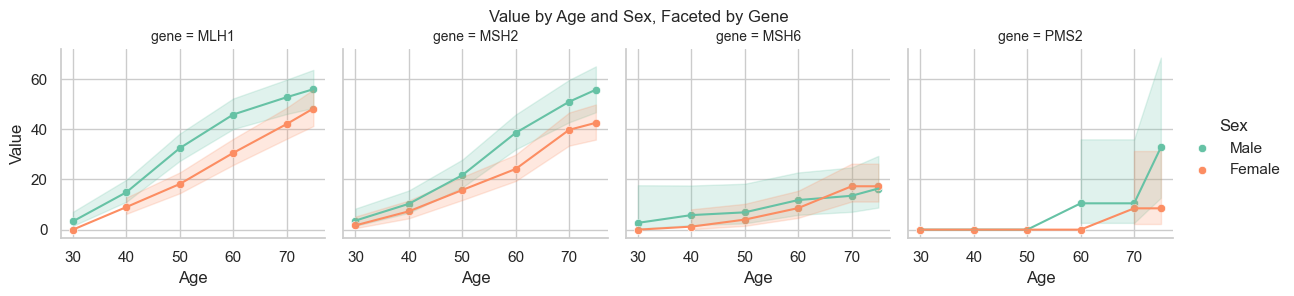

In [80]:
# Create FacetGrid by sex, hue by gene (all genes on same plot per sex)
g = sns.FacetGrid(data, col='gene', hue='sex', height=3, aspect=1, sharey=True, palette="Set2")

# Plot line and scatter
g.map_dataframe(sns.lineplot, x='age', y='value')
g.map_dataframe(sns.scatterplot, x='age', y='value')

# Add confidence intervals
def add_ci(data, **kwargs):
    plt.fill_between(data['age'], data['lower'], data['upper'], 
                     alpha=0.2, color=kwargs.get("color"))

g.map_dataframe(add_ci)

# Format axes and titles
g.set_axis_labels("Age", "Value")
g.add_legend(title="Sex")
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=10)

# Adjust layout
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Value by Age and Sex, Faceted by Gene", fontsize=12)
plt.show()


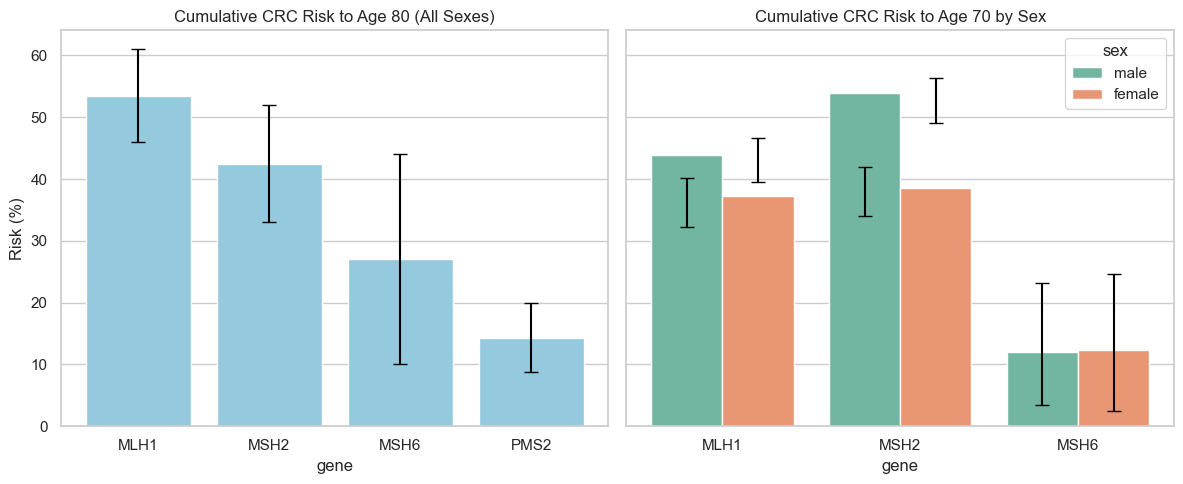

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data for age 80 (sex-agnostic)
data_80 = pd.DataFrame({
    'gene': ['MLH1', 'MSH2', 'MSH6', 'PMS2'],
    'lower': [46, 33, 10, 8.7],
    'upper': [61, 52, 44, 20],
})
data_80['mid'] = (data_80['lower'] + data_80['upper']) / 2

# Data for age 70 (by sex)
data_70 = pd.DataFrame({
    'gene': ['MLH1', 'MSH2', 'MSH6']*2,
    'sex': ['male']*3 + ['female']*3,
    'value': [43.9, 53.9, 12, 37.3, 38.6, 12.3],
    'lower': [39.6, 49, 2.4, 32.2, 34.1, 3.5],
    'upper': [46.6, 56.3, 24.6, 40.2, 42, 23.2]
})

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Panel A
sns.barplot(data=data_80, x='gene', y='mid', ax=axes[0], color='skyblue')
axes[0].errorbar(x=range(len(data_80)), y=data_80['mid'],
                 yerr=[data_80['mid'] - data_80['lower'], data_80['upper'] - data_80['mid']],
                 fmt='none', c='black', capsize=5)
axes[0].set_title("Cumulative CRC Risk to Age 80 (All Sexes)")
axes[0].set_ylabel("Risk (%)")

# Panel B
sns.barplot(data=data_70, x='gene', y='value', hue='sex', ax=axes[1], palette='Set2')
axes[1].set_title("Cumulative CRC Risk to Age 70 by Sex")
axes[1].set_ylabel("")

# Add error bars manually
for i, row in data_70.iterrows():
    axes[1].errorbar(x=i % 3 + (0.2 if row['sex'] == 'male' else -0.2),
                     y=row['value'],
                     yerr=[[row['value'] - row['lower']], [row['upper'] - row['value']]],
                     fmt='none', c='black', capsize=5)

plt.tight_layout()
plt.show()


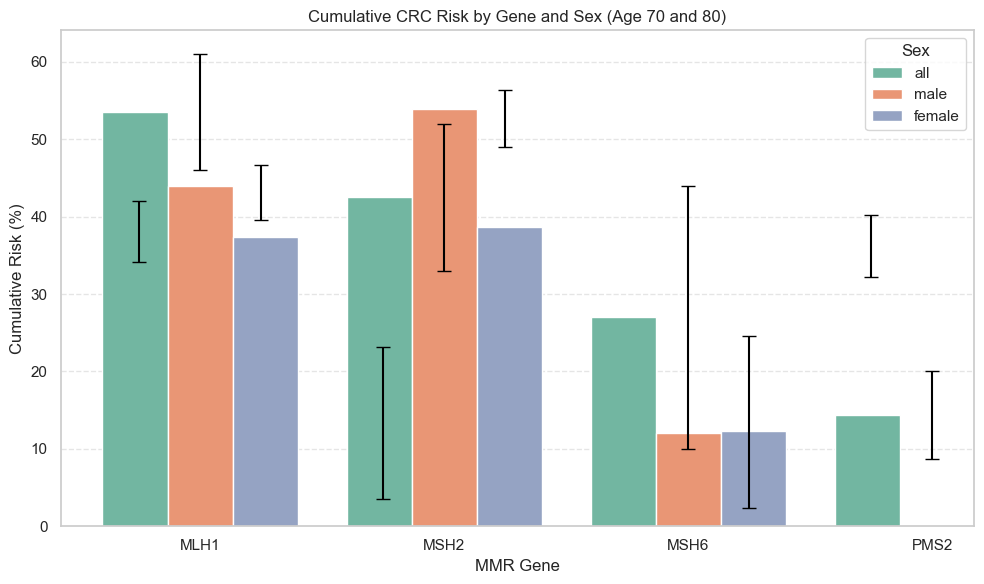

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combined dataset
data_combined = pd.DataFrame({
    'gene': ['MLH1', 'MSH2', 'MSH6', 'PMS2',
             'MLH1', 'MSH2', 'MSH6',
             'MLH1', 'MSH2', 'MSH6'],
    'sex': ['all', 'all', 'all', 'all',
            'male', 'male', 'male',
            'female', 'female', 'female'],
    'lower': [46, 33, 10, 8.7,
              39.6, 49, 2.4,
              32.2, 34.1, 3.5],
    'upper': [61, 52, 44, 20,
              46.6, 56.3, 24.6,
              40.2, 42, 23.2],
    'value': [None]*4 + [43.9, 53.9, 12, 37.3, 38.6, 12.3],
    'age_limit': ['80']*4 + ['70']*6
})

# Fill in midpoints for plotting
data_combined['mid'] = data_combined['value']
data_combined.loc[data_combined['mid'].isna(), 'mid'] = (
    data_combined['lower'] + data_combined['upper']
) / 2

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=data_combined, x='gene', y='mid', hue='sex', palette='Set2')

# Add error bars
for i, row in data_combined.iterrows():
    plt.errorbar(x=i % 4 + [-0.25, 0, 0.25][['female', 'all', 'male'].index(row['sex'])],
                 y=row['mid'],
                 yerr=[[row['mid'] - row['lower']], [row['upper'] - row['mid']]],
                 fmt='none', c='black', capsize=5)

plt.title("Cumulative CRC Risk by Gene and Sex (Age 70 and 80)")
plt.ylabel("Cumulative Risk (%)")
plt.xlabel("MMR Gene")
plt.legend(title='Sex')
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()
